In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [4]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [5]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 10)
        )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.main(x)
        return nn.functional.log_softmax(x, dim=1)
        

In [6]:
discriminator = Discriminator().to(device)

In [7]:
optim_d = optim.Adam(discriminator.parameters(), lr=0.00005)

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [10]:
# function to train the discriminator network
def train_discriminator(optimizer, data, labels):
    optimizer.zero_grad()
    output = discriminator(data)
    # print(output.shape)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    return loss, output

In [16]:
losses = []
accuracies = []
epochs = 50

discriminator.train()

for epoch in range(epochs):
    total = 0
    acc_loss = 0
    correct = 0
    for bi, (images, labels) in enumerate(data_loader):
        loss, output = train_discriminator(optim_d, images, labels)
        acc_loss += loss
        b_size = len(labels)
        total += b_size
        predicted = torch.argmax(output, dim=1)
        correct += (predicted==labels).sum()
        accuracy = correct/total
        avg_loss = loss/b_size
        if bi%20==0:
            print(f"Epoch {epoch}/{epochs}; Batch {bi}: Loss = {loss:.5f}\t\tAccuracy = {accuracy:.5f}")

    
    losses.append(acc_loss/total)
    accuracies.append(accuracy)


Epoch 0/50; Batch 0: Loss = 2.29445		Accuracy = 0.13867
Epoch 0/50; Batch 20: Loss = 1.77127		Accuracy = 0.46968
Epoch 0/50; Batch 40: Loss = 1.23526		Accuracy = 0.55607
Epoch 0/50; Batch 60: Loss = 0.85742		Accuracy = 0.60531
Epoch 0/50; Batch 80: Loss = 0.80718		Accuracy = 0.63800
Epoch 0/50; Batch 100: Loss = 0.65689		Accuracy = 0.66250


KeyboardInterrupt: 

In [16]:
losses0 = [i.detach() for i in losses]

No handles with labels found to put in legend.


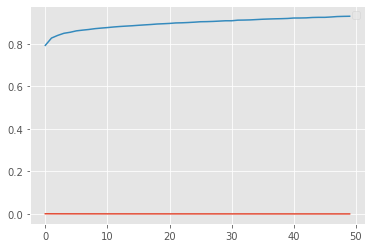

In [19]:
plt.figure()
plt.plot(losses0)
plt.plot(accuracies)
plt.legend()
plt.savefig('./outputs/loss_and_accuracy.png')

In [11]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [27]:
# torch.save(discriminator.state_dict(), "./outputs/fmnist_classifier.pth")

In [12]:
classifier = Discriminator()
classifier.load_state_dict(torch.load("./outputs/fmnist_classifier.pth"))

<All keys matched successfully>

In [15]:
# load model and set to evaluate mode

generator_GAN = Generator(nz)
generator_WGAN = Generator(nz)
# generator_unrolled = Generator(nz)

generator_GAN.load_state_dict(torch.load("./models/vanilla_gan/generator.pth", map_location=torch.device('cpu')))
generator_WGAN.load_state_dict(torch.load("./models/wasserstein/generator.pth", map_location=torch.device('cpu')))
# generator_unrolled.load_state_dict(torch.load("./models/unrolled/generator.pth", map_location=torch.device('cpu')))
generator_GAN.eval()
generator_WGAN.eval()
# print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

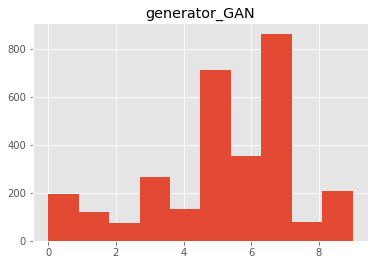

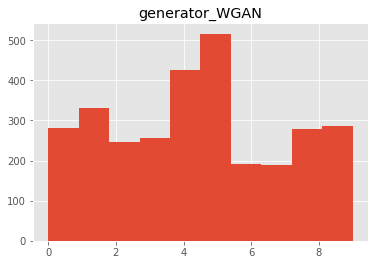

In [21]:
# generate 3,000 new images

sample_size = 3000

def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

nz = 128
# create noise

models = {'generator_GAN': generator_GAN, 'generator_WGAN': generator_WGAN}

for key, generator in models.items():

    noise = create_noise(sample_size, nz)

    # feed noise to generator
    new_images = generator(noise)

    # feed new images to discriminator
    new_softmax = classifier(new_images)
    new_labels = torch.argmax(new_softmax, dim=1)

    plt.figure()
    plt.hist(new_labels.numpy(), bins=10)
    plt.title(key)
    plt.savefig(f"./outputs/new_labels_histogram_{key}.png")

In [17]:
str(generator)

'Generator(\n  (main): Sequential(\n    (0): Linear(in_features=128, out_features=256, bias=True)\n    (1): ReLU()\n    (2): Linear(in_features=256, out_features=512, bias=True)\n    (3): ReLU()\n    (4): Linear(in_features=512, out_features=784, bias=True)\n    (5): Tanh()\n  )\n)'

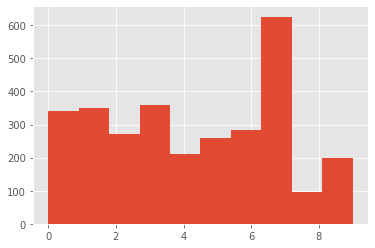

In [38]:
# plot histogram of labels

plt.figure()
plt.hist(new_labels.numpy(), bins=10)
# plt.legend()
plt.savefig("./outputs/new_labels_histogram.png")
plt.show()

(3000,)